### COMP3314 ML
Guo Shunhua 3035447635 
<br>
# <u>Logistic regression Construction</u>

## Overview
1. [Introduction](#s1) 
2. [Logistic regression Model Setup](#s2) 
3. [Load data & Apply to the model](#s3) 
4. [Plotting the result for analysis](#s4)
5. [Parameter Analysis](#s5)


----- 


<a id=’s1’></a>

## 1 Introduction

This notebook will implement a Multi-class Logistic regression and then train implemented model to provided data set.

<u>Import Libraries</u>

In [1]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected")
                    
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

<a id=’s2’></a>

## 2 Logistic regression Model Setup

As the sigmoid function applies to binary classification cases while the softmax function applies to multi-class classification problems, I will implement softmax function first.

In [2]:
def softmax(x):
    """
    input: x as a vector
    output: a vector
    """
    x_exp = [np.exp(i) for i in x]
    x_exp_sum = sum(x_exp)
    return [i / x_exp_sum for i in x_exp]

x = [1, 2, 3, 4]
softmax(x)

[0.03205860328008499,
 0.08714431874203257,
 0.23688281808991013,
 0.6439142598879722]

### Multiclass Logistic Regression Model Construction

In [3]:
class LogisticRegressionMulti(object):
    def __init__(self, learning_rate=0.05, n_iter=1000,
                 regularization_param=0.01, regularization=2, validation=None):
        self.l = learning_rate
        self.n_iter = n_iter
        # 0 = no regularization
        # 1 = L1
        # 2 = L2 (default)
        self.regularization = regularization
        self.r = regularization_param
        
        # if None, then no validation set used
        self.validation = validation
    
    def fit(self, X, y):
        numClass = int(np.max(y)) + 1
        # weight vector include the intercept term
        self.w = np.random.rand(X.shape[1] + 1, numClass)
        self.cost = []
        self.cost_val = []
        self.accu = []
        self.accu_val = []
        
        if self.validation != None:
            if self.validation < len(y):
                X_val = X[self.validation:]
                y_val = y[self.validation:]
                X = X[:self.validation]
                y = y[:self.validation]
            else:
                print("WARNING: validation number input is larger than the data length, no validation set is used.")
                self.validation = None
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            
            #gredient decend 
            grad = self.gradient(output, X, y)
            self.w = self.w - self.l * grad
            
            if self.regularization == 1:
                self.w -= self.r * np.sign(self.w)
            elif self.regularization == 2:
                self.w -= self.r * self.w
            
            # loss function
            loss = self.loss(output, y)
            self.cost.append(loss)
            
            # accuracy 
            self.accu.append(self.accuracy(X, y))
            
            # loss and accuracy for validation set 
            if self.validation != None:
                output_val = self.activation(self.net_input(X_val))
                self.cost_val.append(self.loss(output_val, y_val))
                self.accu_val.append(self.accuracy(X_val, y_val))
                
        return self
    
    def net_input(self, X):
        return np.matmul(X, self.w[1:]) + self.w[0]
    
    def activation(self, z):
        # softmax for multi-class
        return [softmax(i) for i in z]
    
    def gradient(self, output, X, y):
        # output the gradient for weight vector
        # shape is the same as weight vector
        grad = [self.compute_gradients(output[i], X[i], y[i]) for i in range(len(y))]
        gradient = np.reshape(np.mean(grad, axis=0), (X.shape[1] + 1, len(output[0])))
        return gradient

    #calculate gradient for single data point as flattened
    def compute_gradients(self, out, x, y):
        out = np.reshape(out, (len(out), 1))
        out[y] = out[y]-1
        x = np.append(np.array(1), x)
        grad = out * x
        return grad.transpose().flatten()

    def loss(self, output, y):
        loss = sum([-np.log(output[i][int(y[i])]) for i in range(len(y))])
        
        if self.regularization == 1:
            loss += self.r * np.sum(np.abs(self.w))
        elif self.regularization == 2:
            loss += 0.5 * self.r * np.sum(self.w**2) 
        return loss
    
    def predict(self, X):
        net_input = self.net_input(X)
        output = self.activation(net_input)
        return np.argmax(output, 1) # 1 = row argmax
    
    def accuracy(self, X, y):
        correct = [self.predict(X)[i] == int(y[i]) for i in range(len(y))]
        return sum(correct)/len(y) 

<a id=’s3’></a>

## 3 Load data & Apply the model

### Car data set

In [4]:
# Load raw data from csv file, which located in the same folder as this notebook.

X_train_raw = pd.read_csv("dataset_files/car_X_train.csv").to_numpy()
y_train_raw = pd.read_csv("dataset_files/car_y_train.csv").to_numpy()
X_test_raw = pd.read_csv("dataset_files/car_X_test.csv").to_numpy()
y_test_raw = pd.read_csv("dataset_files/car_y_test.csv").to_numpy()

In [5]:
# transform str indicators in data to numeric classes
x_dict = {
    'vhigh' : 4, 
    'high' : 3,
    'med' : 2,
    'low' : 1, 
     
    'small' : 1,
    # 'med' : 2,
    'big' : 3,
    
    # '2' : 2, 
    # '4' : 4,
    'more' : 6, 
    
    '2' : 2, 
    '3' : 3,
    '4' : 4,
    '5more' : 6,
}

y_dict = {
    'acc':1, 'good':2, 'unacc':0, 'vgood':3
}

def transform_X(X):
    for i in range(len(X)):
        x = X[i]
        X[i] = [x_dict[i] for i in x]
    return X

def transform_y(y):
    return [[y_dict[row[0]]] for row in y]

X_train = transform_X(X_train_raw)
y_train = np.array(transform_y(y_train_raw))
X_test = transform_X(X_test_raw)
y_test = np.array(transform_y(y_test_raw))

In [6]:
# Apply the model, and fit the training data
model = LogisticRegressionMulti(learning_rate=0.05, n_iter=50, regularization_param=0.01,
                regularization=2, validation=1000)

model.fit(X_train, y_train)

In [7]:
#test accuracy result
model.accuracy(X_test, y_test)

0.7148362235067437

### Iris data set

In [8]:
# Load data from csv file, which located in the same folder as this notebook.

X_train = pd.read_csv("dataset_files/iris_X_train.csv").to_numpy()
y_train = pd.read_csv("dataset_files/iris_y_train.csv").to_numpy()
X_test = pd.read_csv("dataset_files/iris_X_test.csv").to_numpy()
y_test = pd.read_csv("dataset_files/iris_y_test.csv").to_numpy()

In [9]:
# Apply the model, and fit the training data
model = LogisticRegressionMulti(learning_rate=0.05, n_iter=100, regularization_param=0.01,
                regularization=2, validation=80)

model.fit(X_train, y_train)

In [10]:
#test accuracy result
model.accuracy(X_test, y_test)

0.98

<a id=’s4’></a>

## 4 Plotting the result for analysis

The data set used in this section is Iris Data Set.

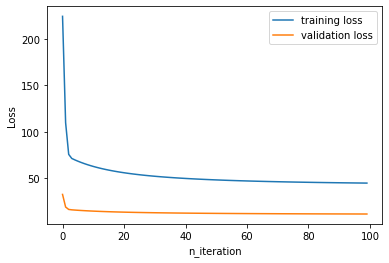

In [11]:
# better including the validation set to analyse
x = np.arange(model.n_iter)

plt.plot(x, model.cost, label="training loss")
plt.plot(x, model.cost_val, label="validation loss")

plt.xlabel("n_iteration")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

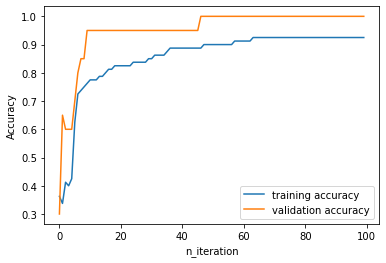

In [12]:
x = np.arange(model.n_iter)

plt.plot(x, model.accu, label="training accuracy")
plt.plot(x, model.accu_val, label="validation accuracy")

plt.xlabel("n_iteration")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

<a id=’s5’></a>

## 5 Parameter Analysis

The data set used in this section is Iris Data Set.

In [13]:
X_ = np.concatenate((X_train, X_test))
y_ = np.concatenate((y_train, y_test))

### Regularization

Param: regularization = 0 (no regularization)

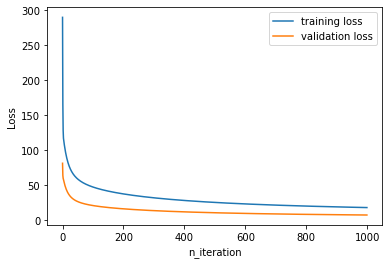

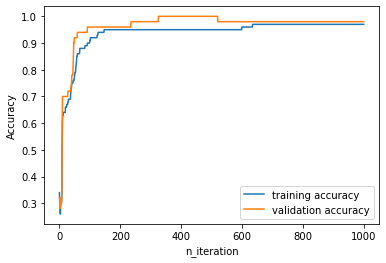

In [14]:
model = LogisticRegressionMulti(regularization=0, validation=100)

model.fit(X_, y_)
# better including the validation set to analyse
x = np.arange(model.n_iter)

plt.plot(x, model.cost, label="training loss")
plt.plot(x, model.cost_val, label="validation loss")

plt.xlabel("n_iteration")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

plt.plot(x, model.accu, label="training accuracy")
plt.plot(x, model.accu_val, label="validation accuracy")

plt.xlabel("n_iteration")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

Param: regularization = 1 (L1 regularization)

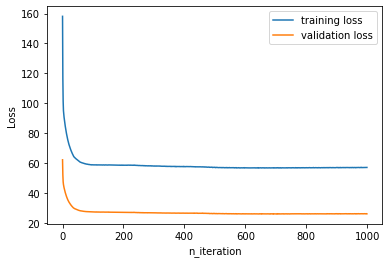

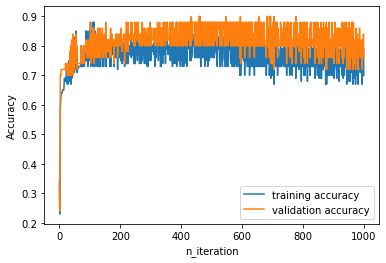

In [15]:
model = LogisticRegressionMulti(regularization_param=0.005, regularization=1, validation=100)

model.fit(X_, y_)
# better including the validation set to analyse
x = np.arange(model.n_iter)

plt.plot(x, model.cost, label="training loss")
plt.plot(x, model.cost_val, label="validation loss")

plt.xlabel("n_iteration")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

plt.plot(x, model.accu, label="training accuracy")
plt.plot(x, model.accu_val, label="validation accuracy")

plt.xlabel("n_iteration")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

Param: regularization = 2 (L2 regularization)

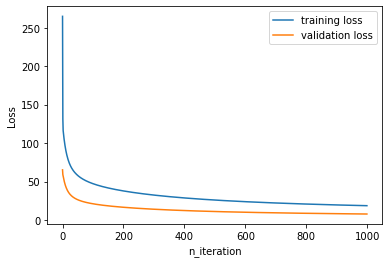

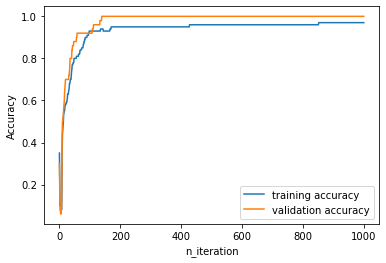

In [16]:
model = LogisticRegressionMulti(regularization=0, validation=100)

model.fit(X_, y_)
# better including the validation set to analyse
x = np.arange(model.n_iter)

plt.plot(x, model.cost, label="training loss")
plt.plot(x, model.cost_val, label="validation loss")

plt.xlabel("n_iteration")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

plt.plot(x, model.accu, label="training accuracy")
plt.plot(x, model.accu_val, label="validation accuracy")

plt.xlabel("n_iteration")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()